In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

from google.colab import files
from google.colab import drive
drive.mount('/drive')

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

%matplotlib inline

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# Импорт данных

In [ ]:
df_origin = pd.read_csv('/drive/MyDrive/!SberDataScience/Курсовой проект/!main/dataset/final_without_fill_na_salary.csv')

In [ ]:
test = df_origin[(df_origin.index % 9)==0].copy()

In [ ]:
train = df_origin[(df_origin.index % 9)!=0].copy()

In [ ]:
train = train.reset_index()
train = train.drop('index', axis=1)

test = test.reset_index()
test = test.drop('index', axis=1)

# Предварительный просмотр

In [ ]:
train.shape , test.shape

((857, 12), (108, 12))

In [ ]:
pd.pandas.set_option('display.max_columns',None)
train.head()

,Employer,Name,Salary,From,To,Experience,Schedule,Skills,Description,Category,Position_level,Salary_median
0,FunBox,Python-разработчик,True,170000.0,210000.0,От 1 года до 3 лет,Полный день,"Python,Django,Git,Linux,Работа в команде",Вам предстоит участвовать в разработке сложных...,Python Develop,Middle,190000.0
1,Spark Equation,Data Scientist (Remote),True,120000.0,190000.0,От 3 до 6 лет,Удаленная работа,"Machine Learning,Python,Java,SQL,Data Mining,D...",Spark Equation is a software-enabled IT and st...,Data Science,other,155000.0
2,Vilesse,Разработчик Python,True,130500.0,174000.0,От 3 до 6 лет,Удаленная работа,"Python,CSS,JavaScript,React,Docker,Git,HTML5,D...",О нас:Мы - международная софтверная компания с...,Python Develop,other,152250.0
3,GetConduit.app,Разработчик Python Middle/Senior - Remote,True,186667.0,226667.0,От 3 до 6 лет,Удаленная работа,"Django Framework,Python,Git,PostgreSQL",Мы делаем аналитический продукт для e-commerce...,Python Develop,Middle,206667.0
4,Skyeng,Data Analyst в Acquisition Analytics Team,True,130000.0,180000.0,От 1 года до 3 лет,Полный день,"Python,SQL,Tableau,Анализ данных",Skyeng — трендсеттеры в онлайн-образовании. Ка...,Data Analysis,Middle,155000.0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Employer        857 non-null    object 
 1   Name            857 non-null    object 
 2   Salary          857 non-null    bool   
 3   From            857 non-null    float64
 4   To              857 non-null    float64
 5   Experience      857 non-null    object 
 6   Schedule        857 non-null    object 
 7   Skills          857 non-null    object 
 8   Description     857 non-null    object 
 9   Category        857 non-null    object 
 10  Position_level  857 non-null    object 
 11  Salary_median   857 non-null    float64
dtypes: bool(1), float64(3), object(8)
memory usage: 74.6+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Employer        108 non-null    object 
 1   Name            108 non-null    object 
 2   Salary          108 non-null    bool   
 3   From            108 non-null    float64
 4   To              108 non-null    float64
 5   Experience      108 non-null    object 
 6   Schedule        108 non-null    object 
 7   Skills          108 non-null    object 
 8   Description     108 non-null    object 
 9   Category        108 non-null    object 
 10  Position_level  108 non-null    object 
 11  Salary_median   108 non-null    float64
dtypes: bool(1), float64(3), object(8)
memory usage: 9.5+ KB


В учебном наборе имеем 1460 записей (строк) и 81 столбец, содержащие три типа данных (целочисленные, с плавающей запятой и объектные). Рассмотрим целевой столбец SalePrice дополнительно

In [ ]:
print(train['Salary_median'].describe())

count    8.570000e+02
mean     1.934603e+05
std      1.033361e+05
min      2.000000e+04
25%      1.200000e+05
50%      1.800000e+05
75%      2.500000e+05
max      1.200000e+06
Name: Salary_median, dtype: float64


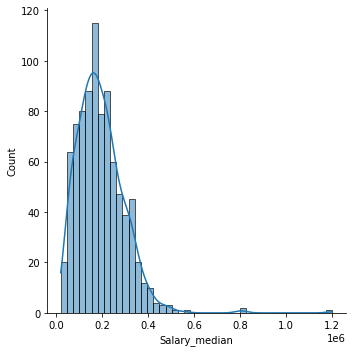

In [ ]:
sns.displot(train['Salary_median'], kde = 'True' )
plt.show()

Исходя из вида графика можно предположить, что цена является нормальным распределением. 

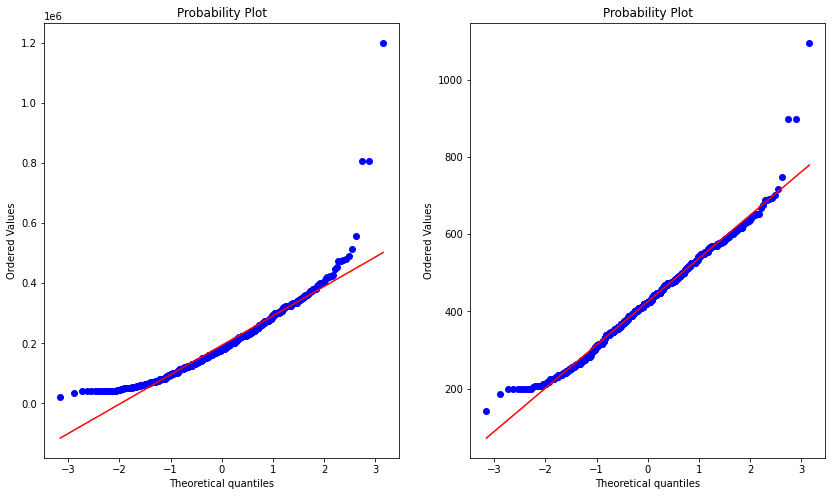

In [ ]:
fig = plt.figure(figsize = (14,8))

# Распределение на необработанных данных
fig.add_subplot(1,2,1)
res = stats.probplot(train['Salary_median'], plot=plt)

# Распределение при условии, что взяли квадратный корень
fig.add_subplot(1,2,2)
res = stats.probplot(np.sqrt(train['Salary_median']), plot=plt)

Применим к тестовой выборке

In [ ]:
train['Salary_median'] = np.sqrt(train['Salary_median'])

Удаление избыточных признаков

In [ ]:
#Employer, Salary, From, To, Description

features_drop = ['Employer','Salary','From','To', 'Description']
train = train.drop(features_drop, axis=1)
test = test.drop(features_drop, axis=1)

In [ ]:
#Объеденим обе выборки для преобразований
all_data = pd.concat([train.iloc[:,:-1], test.iloc[:,:-1]],axis=0)


In [ ]:
all_data.shape

(965, 6)

In [ ]:
def listmerge(lstlst):
  """
  Функция, которая преобразует список списков в один общий список
  lstlst - список списков
  """
  all=[]
  for lst in lstlst:
    all.extend(lst)
  return all

In [ ]:
list_str = all_data['Skills'].str.split(',').tolist()
all_str_lst = listmerge(list_str)
all_str_lst = list(set(all_str_lst))

all_data[all_str_lst] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3645: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = value


In [ ]:
len(all_str_lst)

233

In [ ]:
all_data = all_data.reset_index()
all_data = all_data.drop('index', axis=1)

In [ ]:
#Заполним поля единицами, в которых присутствует необходимый навык
for idx in all_data.index:
  skills_list = all_data.at[idx,'Skills'].split(',')
  for el in skills_list:
    if el in all_str_lst:
      all_data.loc[idx, el] = 1

In [ ]:
# Преобразуем категориальные признаки

def OneHotEncoding(df, columnsToEncode):
    return pd.get_dummies(df, columns=columnsToEncode)

cat_cols = ['Experience', 'Schedule', 'Category', 'Position_level']
all_data = OneHotEncoding(all_data, cat_cols)


In [ ]:
all_data = all_data.drop(['Name', 'Skills'], axis=1)

In [ ]:
all_data.head()

,BI,Linux,Sas,Организаторские навыки,Pandas,Power BI,Databases,Базовые знания и понимание игры СS:GO,Agile,Data Engineer,API,C++,MATLAB,Нейронные сети,Удаленная работа,Teradata,Google Docs,aiohttp,Мобильность,CI/CD,docker,Математический анализ,Маркетинговый анализ,Mathematical Analysis,Power Query,SSRS,DWH,Transact-SQL,ClickHouse,Tornado,Data Analysis,HTML,XML,MS Power BI,Управление командой,Сбор и анализ информации,Docker,PowerBI,FastAPI,ML,C#,Информационные технологии,Системный анализ,Маркетинговые исследования,pytorch,Rabbit,HTTP,Atlassian Jira,Знание базы данных PostgreSQL,Django,MS Excel,Разработка нового продукта,Разработка ПО,DRF,Django Framework,Data Scientist,SciPy,C/C++,Hadoop,Unit Testing,numpy,Машинное обучение,PySpark,Azure,Python,Анализ текущих финансовых показателей,Tableau,ORACLE,MySQL,Celery,ETL,BPMN,Data Science,Agile Project Management,Gitlab,Vertica,SSAS,JavaScript,Прогнозирование,Machine learning,FastApi,MS SQL,sklearn,QlikView,Работа в команде,Тестирование,SQL,Деловая переписка,Business Intelligence Systems,ООП,pandas,hadoop,DAX,Оптимизация кода,Data Engineering,A/B тесты,Apache NiFi,VBA,Аналитические исследования,Обучение,Keras,R,Обучение и развитие,Базы данных,Deep Learning,Kubernetes,MS Access,Google Cloud Platform,REST API,Управленческая отчетность,Статистика,Оптимизация запросов,NumPy,IT,MS Visio,Поиск информации в интернет,Redis,Apache Airflow,jQuery,Informatica,Django/Flask,Numpy,Проведение презентаций,Airflow,Грамотность,JSON API,airflow,Mathematical Statistics,TCP/IP,MS SQL Server,Аналитика,asyncio,Data Mining,TensorFlow,Atlassian Confluence,Подготовка презентаций,Микросервисы,Golang,Ориентация на результат,Greenplum,Jenkins,Elasticsearch,Matplotlib,Бизнес-анализ,Bash,AWS,Работа в условиях многозадачности,CSS,Анализ данных,Node.js,Java,PostgreSQL,Clickhouse,BackEnd,Unix,HTML5,Статистический анализ,Analytical skills,Сводные таблицы,Grafana,Работа с базами данных,Oracle BI,Системное мышление,REST,MS PowerPoint,Google Analytics,Docker-compose,Kafka,Грамотная речь,Mathematical Modeling,SOAP,Cистемы управления базами данных,Преподаватель,Scikit-learn,Tensorflow,PyTorch,PHP,Excel,CRM,Работа с большим объемом информации,RabbitMQ,Разработка технических заданий,HDFS,Математическая статистика,Руководство коллективом,Ansible,Анализ бизнес показателей,React,Scrum,Hive,MS Outlook,MongoDB,Computer Vision,Asyncio,English,SQLAlchemy,Визуализация данных,Деловая коммуникация,Olap (online analytical processing),Big Data,ORM,Oracle Pl/SQL,Управление проектами,Jira,Теория вероятностей,Математическое моделирование,NoSQL,data science,Spark,SQL запросы,SSIS,ElasticSearch,Английский язык,Развитие продаж,Qlik Sense,TDD,Flask,Go,SCALA,СУБД,NLP,Machine Learning,Алгоритмы,OpenCV,Nginx,Аналитическое мышление,Git,Backend,Time management,Умение принимать решения,Пользователь ПК,UML,Aiohttp,Experience_Более 6 лет,Experience_Нет опыта,Experience_От 1 года до 3 лет,Experience_От 3 до 6 лет,Schedule_Гибкий график,Schedule_Полный день,Schedule_Сменный график,Schedule_Удаленная работа,Category_Data Analysis,Category_Data Engineer,Category_Data Science,Category_Python Develop,Position_level_Junior,Position_level_Lead,Position_level_Middle,Position_level_Senior,Position_level_other
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
print(all_data.shape)

#Разобъем данные обратно на тренировачную и тестовы
train_data = all_data.iloc[:857, :]
test_data = all_data.iloc[857:, :]



(965, 250)


In [ ]:
test_data.shape

(108, 250)

# Моделирование

Будем использовать RidgeCV(гребневая регрессия) - это один из методов понижения размерности. Его как раз применяют для борьбы с переизбыточностью данных, когда независимые переменные коррелируют друг с другом. И применим XGBoost, в основе которого лежит алгоритм градиентного бустинга деревьев решений. И завершим ансанблированием, взяв усредненное решение двух моделей

In [ ]:
from sklearn.linear_model import RidgeCV

ridge_cv = RidgeCV(alphas = (0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
ridge_cv.fit(train_data, train.Salary_median)
ridge_cv_preds = np.power(ridge_cv.predict(test_data), 2)

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(n_estimators=800, max_depth=2, learning_rate=0.15)
model_xgb.fit(train_data, train.Salary_median)
xgb_preds = np.power(model_xgb.predict(test_data), 2)

[09:15:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#усреднение результатов
predictions = (ridge_cv_preds + xgb_preds) / 2


In [ ]:
test['predictions'] = predictions

In [ ]:
test['predictions_xgb'] = xgb_preds
test['predictions_ridge_cv'] = ridge_cv_preds

In [ ]:
y_pred = predictions
y_test = test['Salary_median'].to_numpy()

In [ ]:
mean_absolute_error(y_test,y_pred)

47995.49516948437

In [ ]:
type(y_test)

numpy.ndarray

In [ ]:
type(y_pred)

numpy.ndarray

In [ ]:
test.head(60)

,Name,Experience,Schedule,Skills,Category,Position_level,Salary_median,predictions,predictions_xgb,predictions_ridge_cv
0,Backend Python Developer (middle/team lead),От 3 до 6 лет,Полный день,"Git,Redis,Django Framework,Базы данных,Python,...",Python Develop,Middle,170000.0,217529.823135,217062.578125,217997.068144
1,Middle Python developer (релокация в Сочи),От 1 года до 3 лет,Полный день,"Python,jQuery,PostgreSQL,Django Framework,Ngin...",Python Develop,Middle,170000.0,151444.933650,151885.984375,151003.882924
2,Python Developer,От 1 года до 3 лет,Полный день,"Python,asyncio",Python Develop,Middle,250000.0,211670.158362,231474.218750,191866.097974
3,Data Engineer,От 3 до 6 лет,Удаленная работа,"SQL,SCALA,Spark,Java,AWS",Data Engineer,other,285000.0,299618.403631,293961.656250,305275.151012
4,Аналитик данных,От 1 года до 3 лет,Полный день,"Python,SQL,MS SQL,Аналитические исследования,А...",Data Analysis,Middle,187050.0,110228.990186,114432.203125,106025.777247
5,Data Analyst,От 3 до 6 лет,Гибкий график,"R,Data Analysis,SQL,Python,Power BI,Статистика...",Data Analysis,other,225000.0,163583.785522,168505.843750,158661.727294
6,Machine Learning / Python Developer,От 1 года до 3 лет,Полный день,"Python,OpenCV,PostgreSQL,Tensorflow,Computer V...",Python Develop,Middle,84400.0,189202.385420,201103.218750,177301.552090
7,Программист Python,От 1 года до 3 лет,Полный день,"Python,JSON API,Git,Linux",Python Develop,Middle,120000.0,120039.806777,108923.867188,131155.746367
8,Data Scientist (middle or senior),От 3 до 6 лет,Гибкий график,"Python,Data Mining,SQL,Математическое моделиро...",Data Science,Middle,412500.0,317971.723230,354246.406250,281697.040209
9,Team Lead Data Analyst,От 3 до 6 лет,Гибкий график,"Python,SQL,Spark,Анализ данных,Статистический ...",Data Analysis,Lead,217500.0,299324.343461,321559.406250,277089.280672
